In [2]:
import torch

In [3]:
from models.transformer import Transformer, TransformerConfig

In [16]:
config_file = 'configs/de-en-v1-sp-mutli30k/model.yaml'
from yaml import safe_load
with open(config_file) as f:
	config = safe_load(f)
config = TransformerConfig(**config['init_args'])
config.output_attention = True

In [17]:
from toknizers import SPTokenizer

tokenizer = SPTokenizer('data/multi30k/m_en_de.model')

In [18]:
model = Transformer(config, tokenizer)
model.load_from_checkpoint('test_multi30k/test_multi30k/checkpoints/model-epoch=70-step=16046-val_loss=3.83.ckpt')

Transformer(
  (criterion): CrossEntropyLoss()
  (src_embeddings): PosNTokEmbedding(
    (token_embedding_table): Embedding(15000, 512)
    (position_embedding_table): PositionalEmbedding()
  )
  (tgt_embeddings): PosNTokEmbedding(
    (token_embedding_table): Embedding(15000, 512)
    (position_embedding_table): PositionalEmbedding()
  )
  (encoder): TransformerEncoder(
    (blocks): ModuleList(
      (0-5): 6 x TransformerEncoderBlock(
        (sa_module): MultiHeadSelfAttention(
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (qkv_projection): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
        )
        (fw_module): TransformerFeedFoward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='tanh')
            (2): Linear(in_features=2048, out_f

In [19]:
from datasets.translate import TranslationDataset, TranslationDatasetConfig

config = TranslationDatasetConfig(
	max_seq_len= 128,
    src_file= 'data/multi30k/train.de',
    src_sp_model_file= 'data/multi30k/m_en_de.model',
    tgt_file= 'data/multi30k/train.en',
    tgt_sp_model_file= 'data/multi30k/m_en_de.model'
)

dataset = TranslationDataset(config)

Reading input files...
                                                 src  \
0  Zwei junge weiße Männer sind im Freien in der ...   
1  Mehrere Männer mit Schutzhelmen bedienen ein A...   
2  Ein kleines Mädchen klettert in ein Spielhaus ...   
3  Ein Mann in einem blauen Hemd steht auf einer ...   
4  Zwei Männer stehen am Herd und bereiten Essen zu.   
5  Ein Mann in grün hält eine Gitarre, während de...   
6     Ein Mann lächelt einen ausgestopften Löwen an.   
7  Ein schickes Mädchen spricht mit dem Handy wäh...   
8  Eine Frau mit einer großen Geldbörse geht an e...   
9     Jungen tanzen mitten in der Nacht auf Pfosten.   

                                                 tgt  
0  Two young, White males are outside near many b...  
1  Several men in hard hats are operating a giant...  
2    A little girl climbing into a wooden playhouse.  
3  A man in a blue shirt is standing on a ladder ...  
4           Two men are at the stove preparing food.  
5  A man in green holds a guit

In [20]:
dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=TranslationDataset.get_collate_function())

In [21]:
batch = next(iter(dl))

In [22]:
batch

TransformerInputBatch(x_src=tensor([[    1,   156,   135,    16,   100,  1656,   251,   705,   162,   734,
         14900,     4,   116, 14900, 14953,  9949,  1732,     7, 13429, 14917,
             2]]), x_tgt=tensor([[    1, 14900, 14932,   133,   217, 14930, 14900, 14942, 14910,    13,
         14901,  4034,   132,   459,   574,  1850,  6029, 14917]]), x_src_mask=tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True]]), x_tgt_mask=tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True]]), y_tgt=tensor([[14900, 14932,   133,   217, 14930, 14900, 14942, 14910,    13, 14901,
          4034,   132,   459,   574,  1850,  6029, 14917,     2]]))

In [23]:
output = model(batch.x_src, batch.x_tgt, batch.x_src_mask, batch.x_tgt_mask)
output.shape

torch.Size([1, 18, 15000])

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

def plot_attention_weights(attention_weights: dict, head: int = 0):
	n_columns = 4
	n_rows = len(attention_weights) // n_columns + 1
	fig_size = (n_columns * 5, n_rows * 4)
	fig, axs = plt.subplots(n_rows, n_columns, figsize=fig_size)
	for i, (name, weights) in enumerate(attention_weights.items()):
		ax = axs[i // n_columns, i % n_columns]
		ax.set_title(name)
		sns.heatmap(weights[0, head].detach().numpy(), ax=ax)
	fig.tight_layout()
	fig.savefig(f'nmt_{head}.png')


[None, None, None]

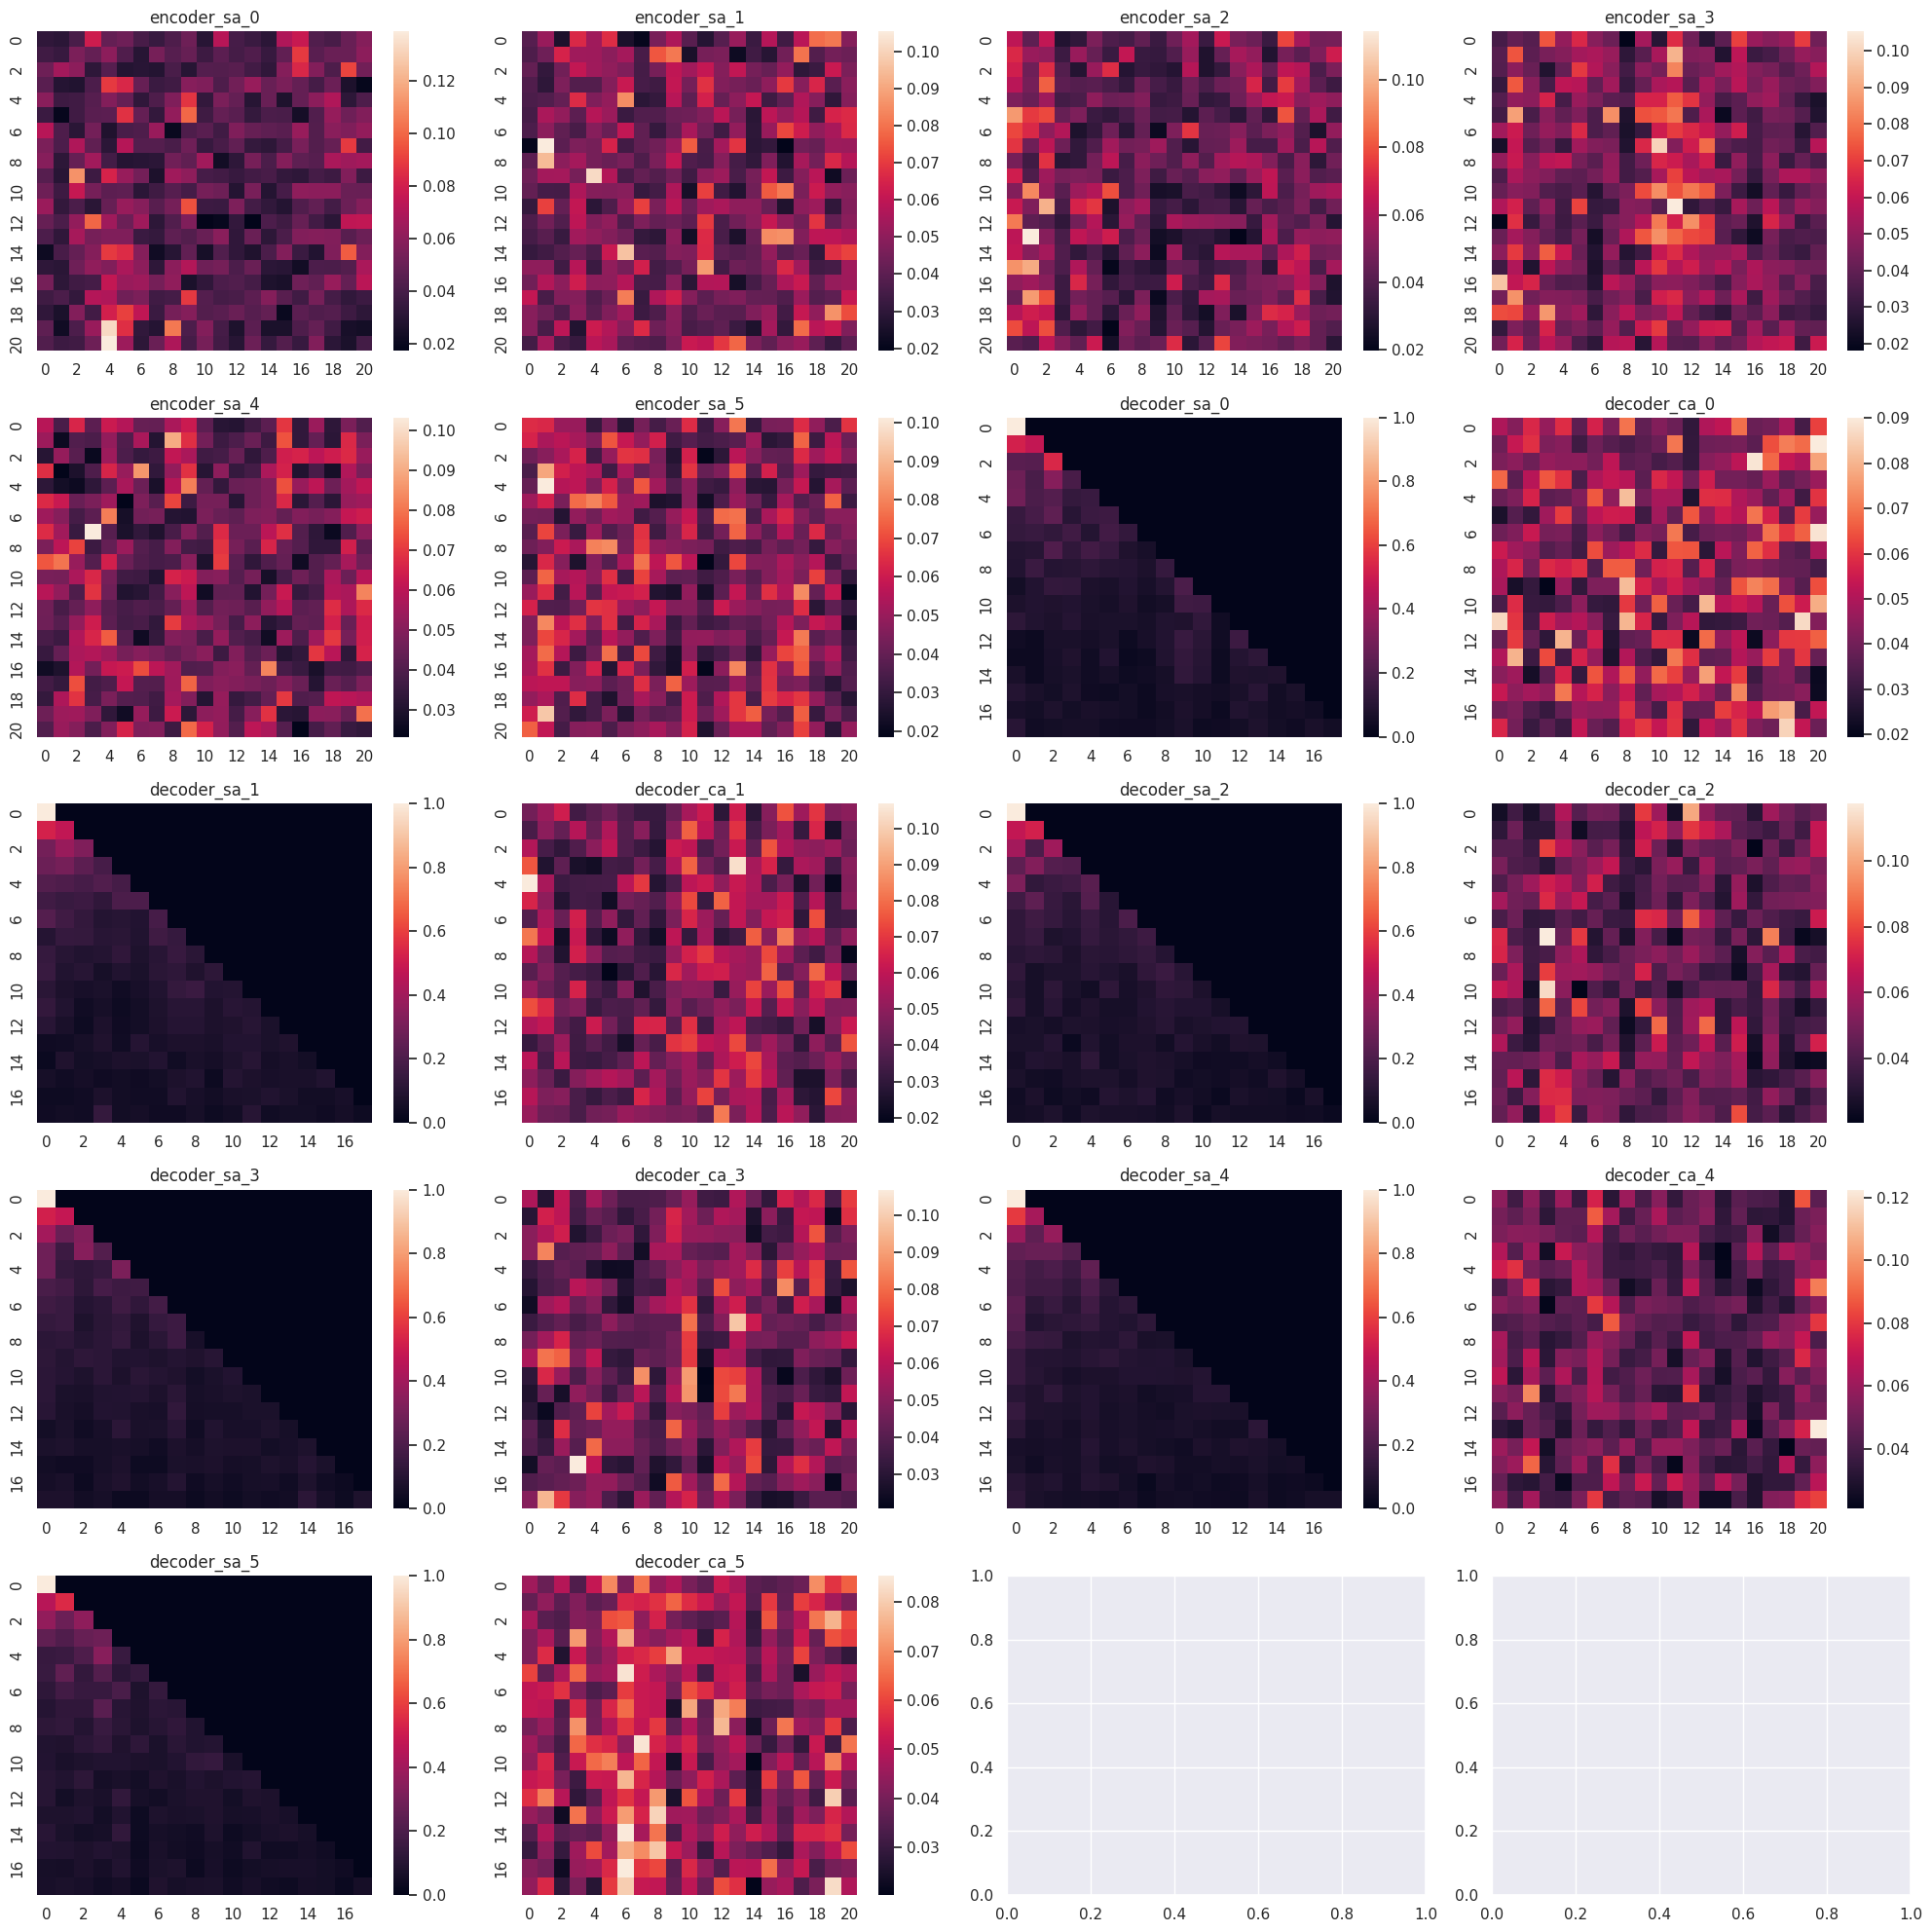

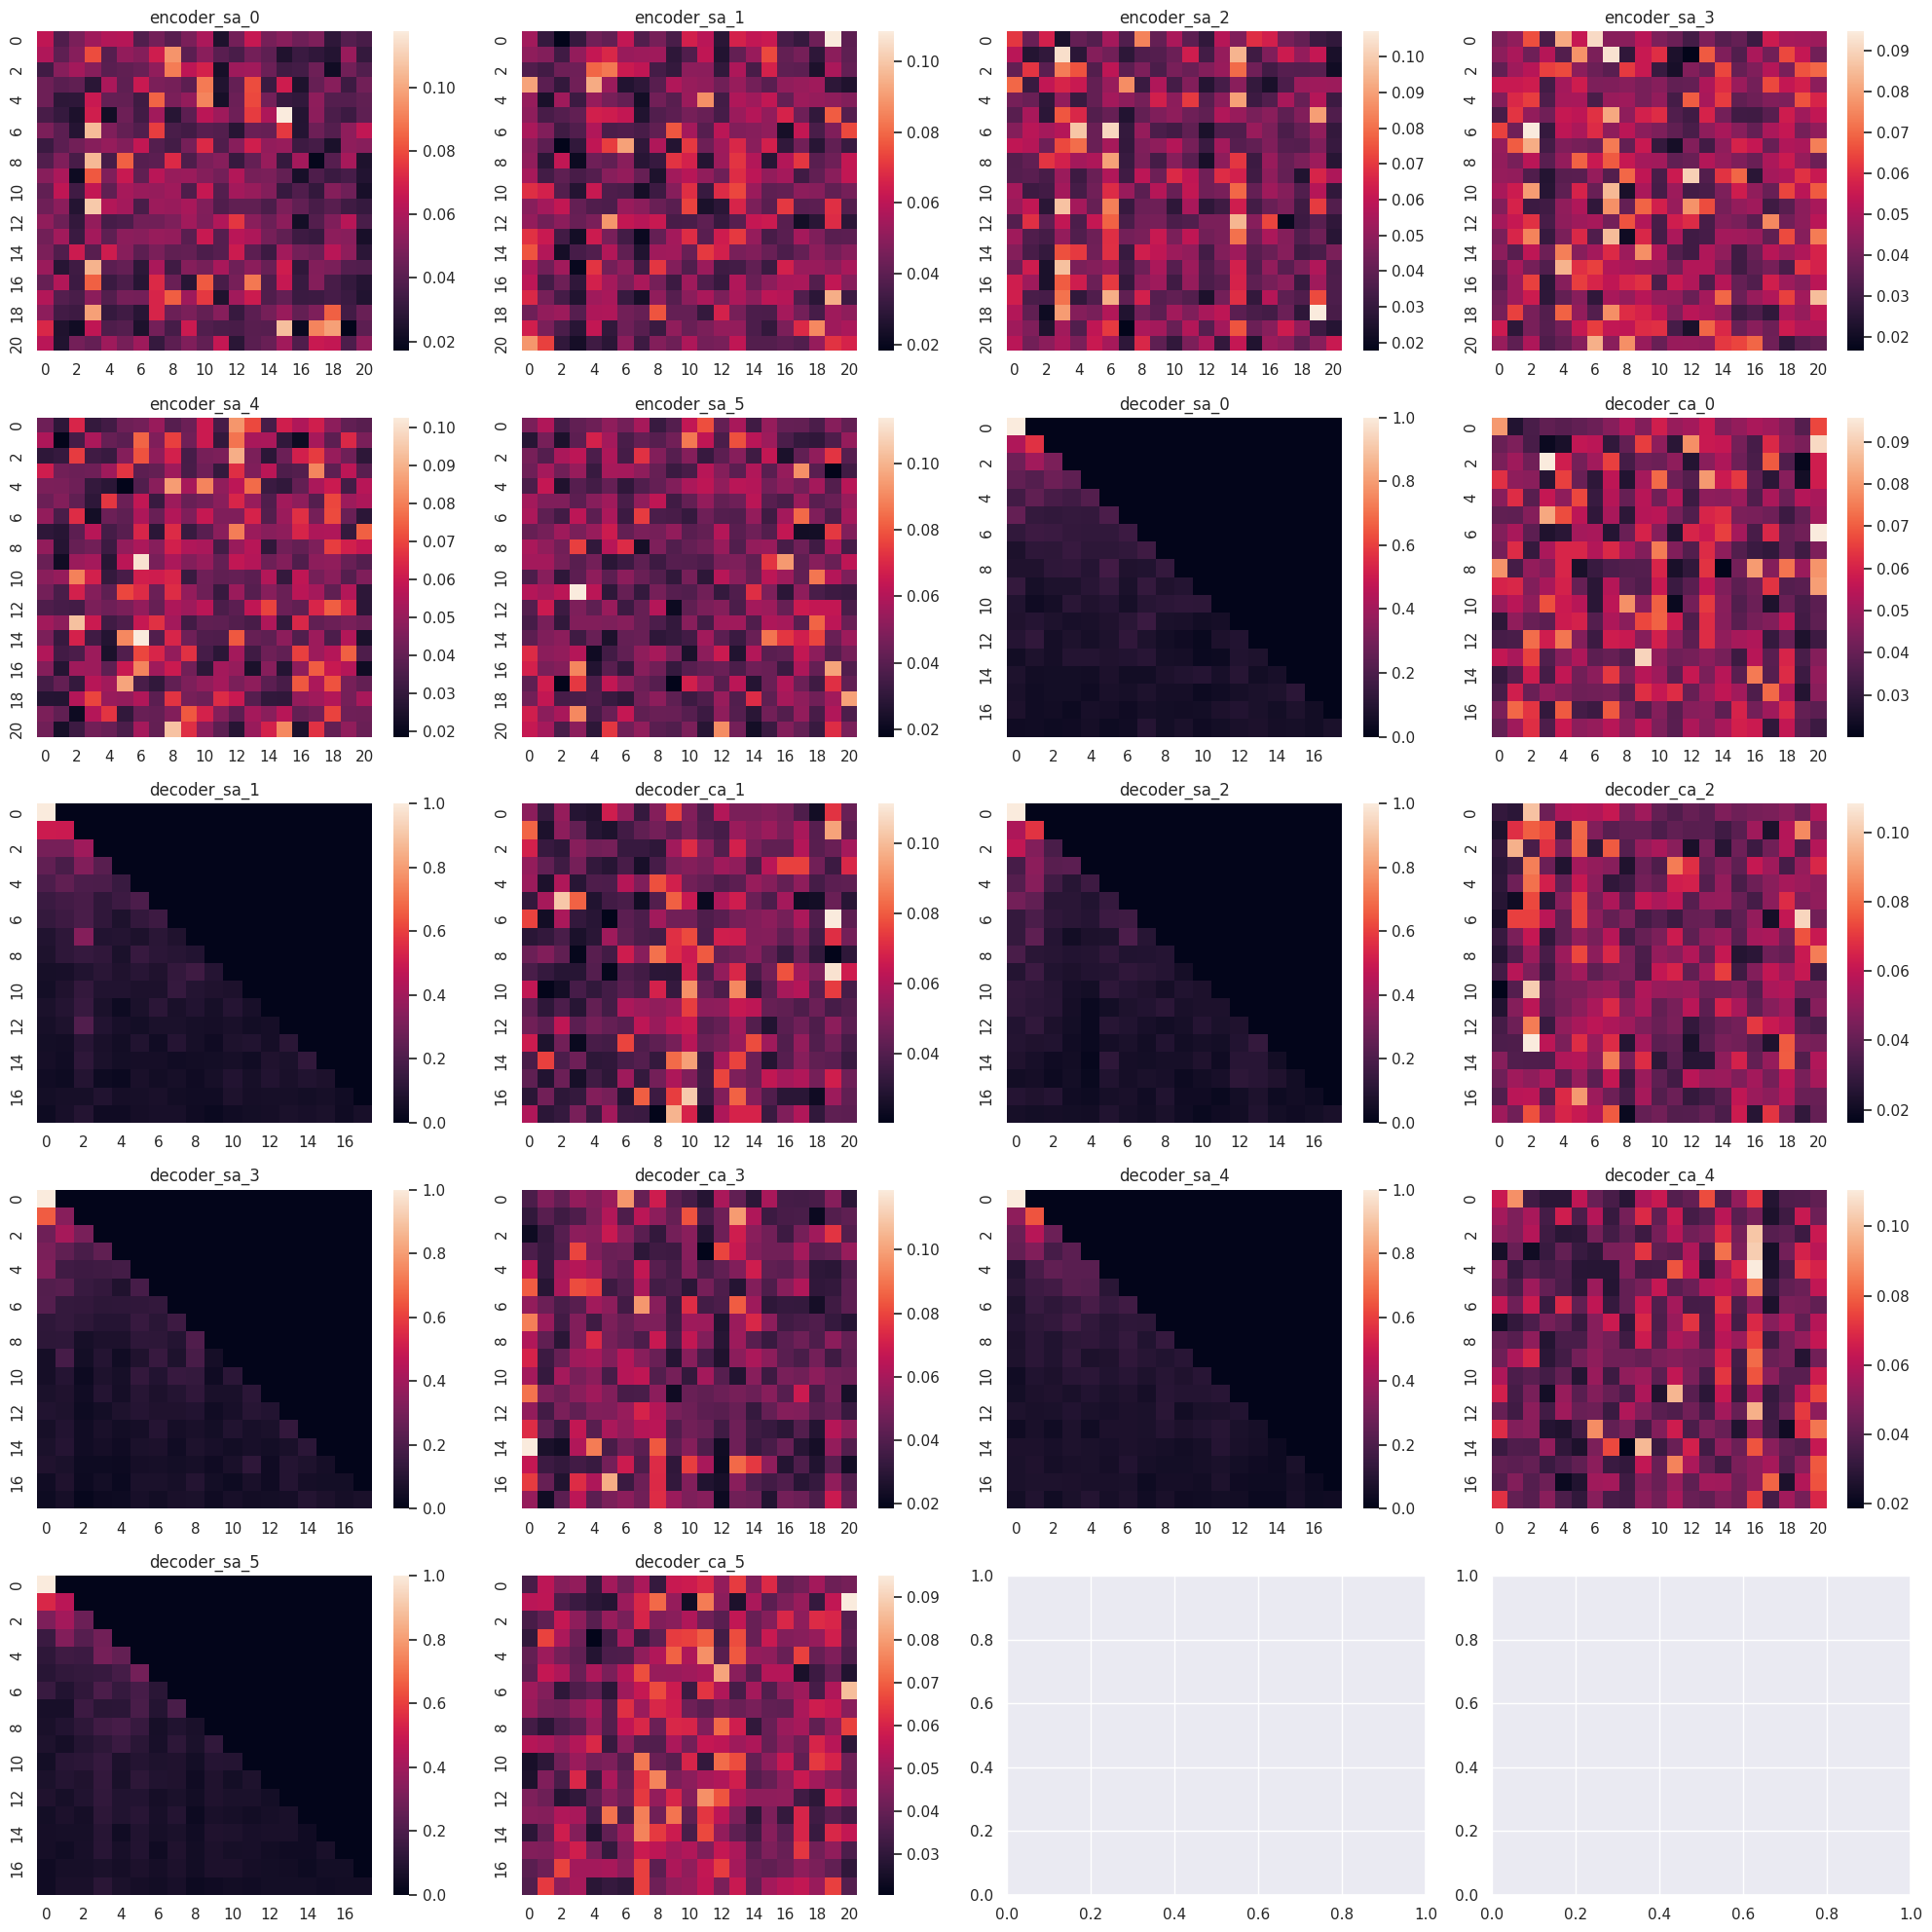

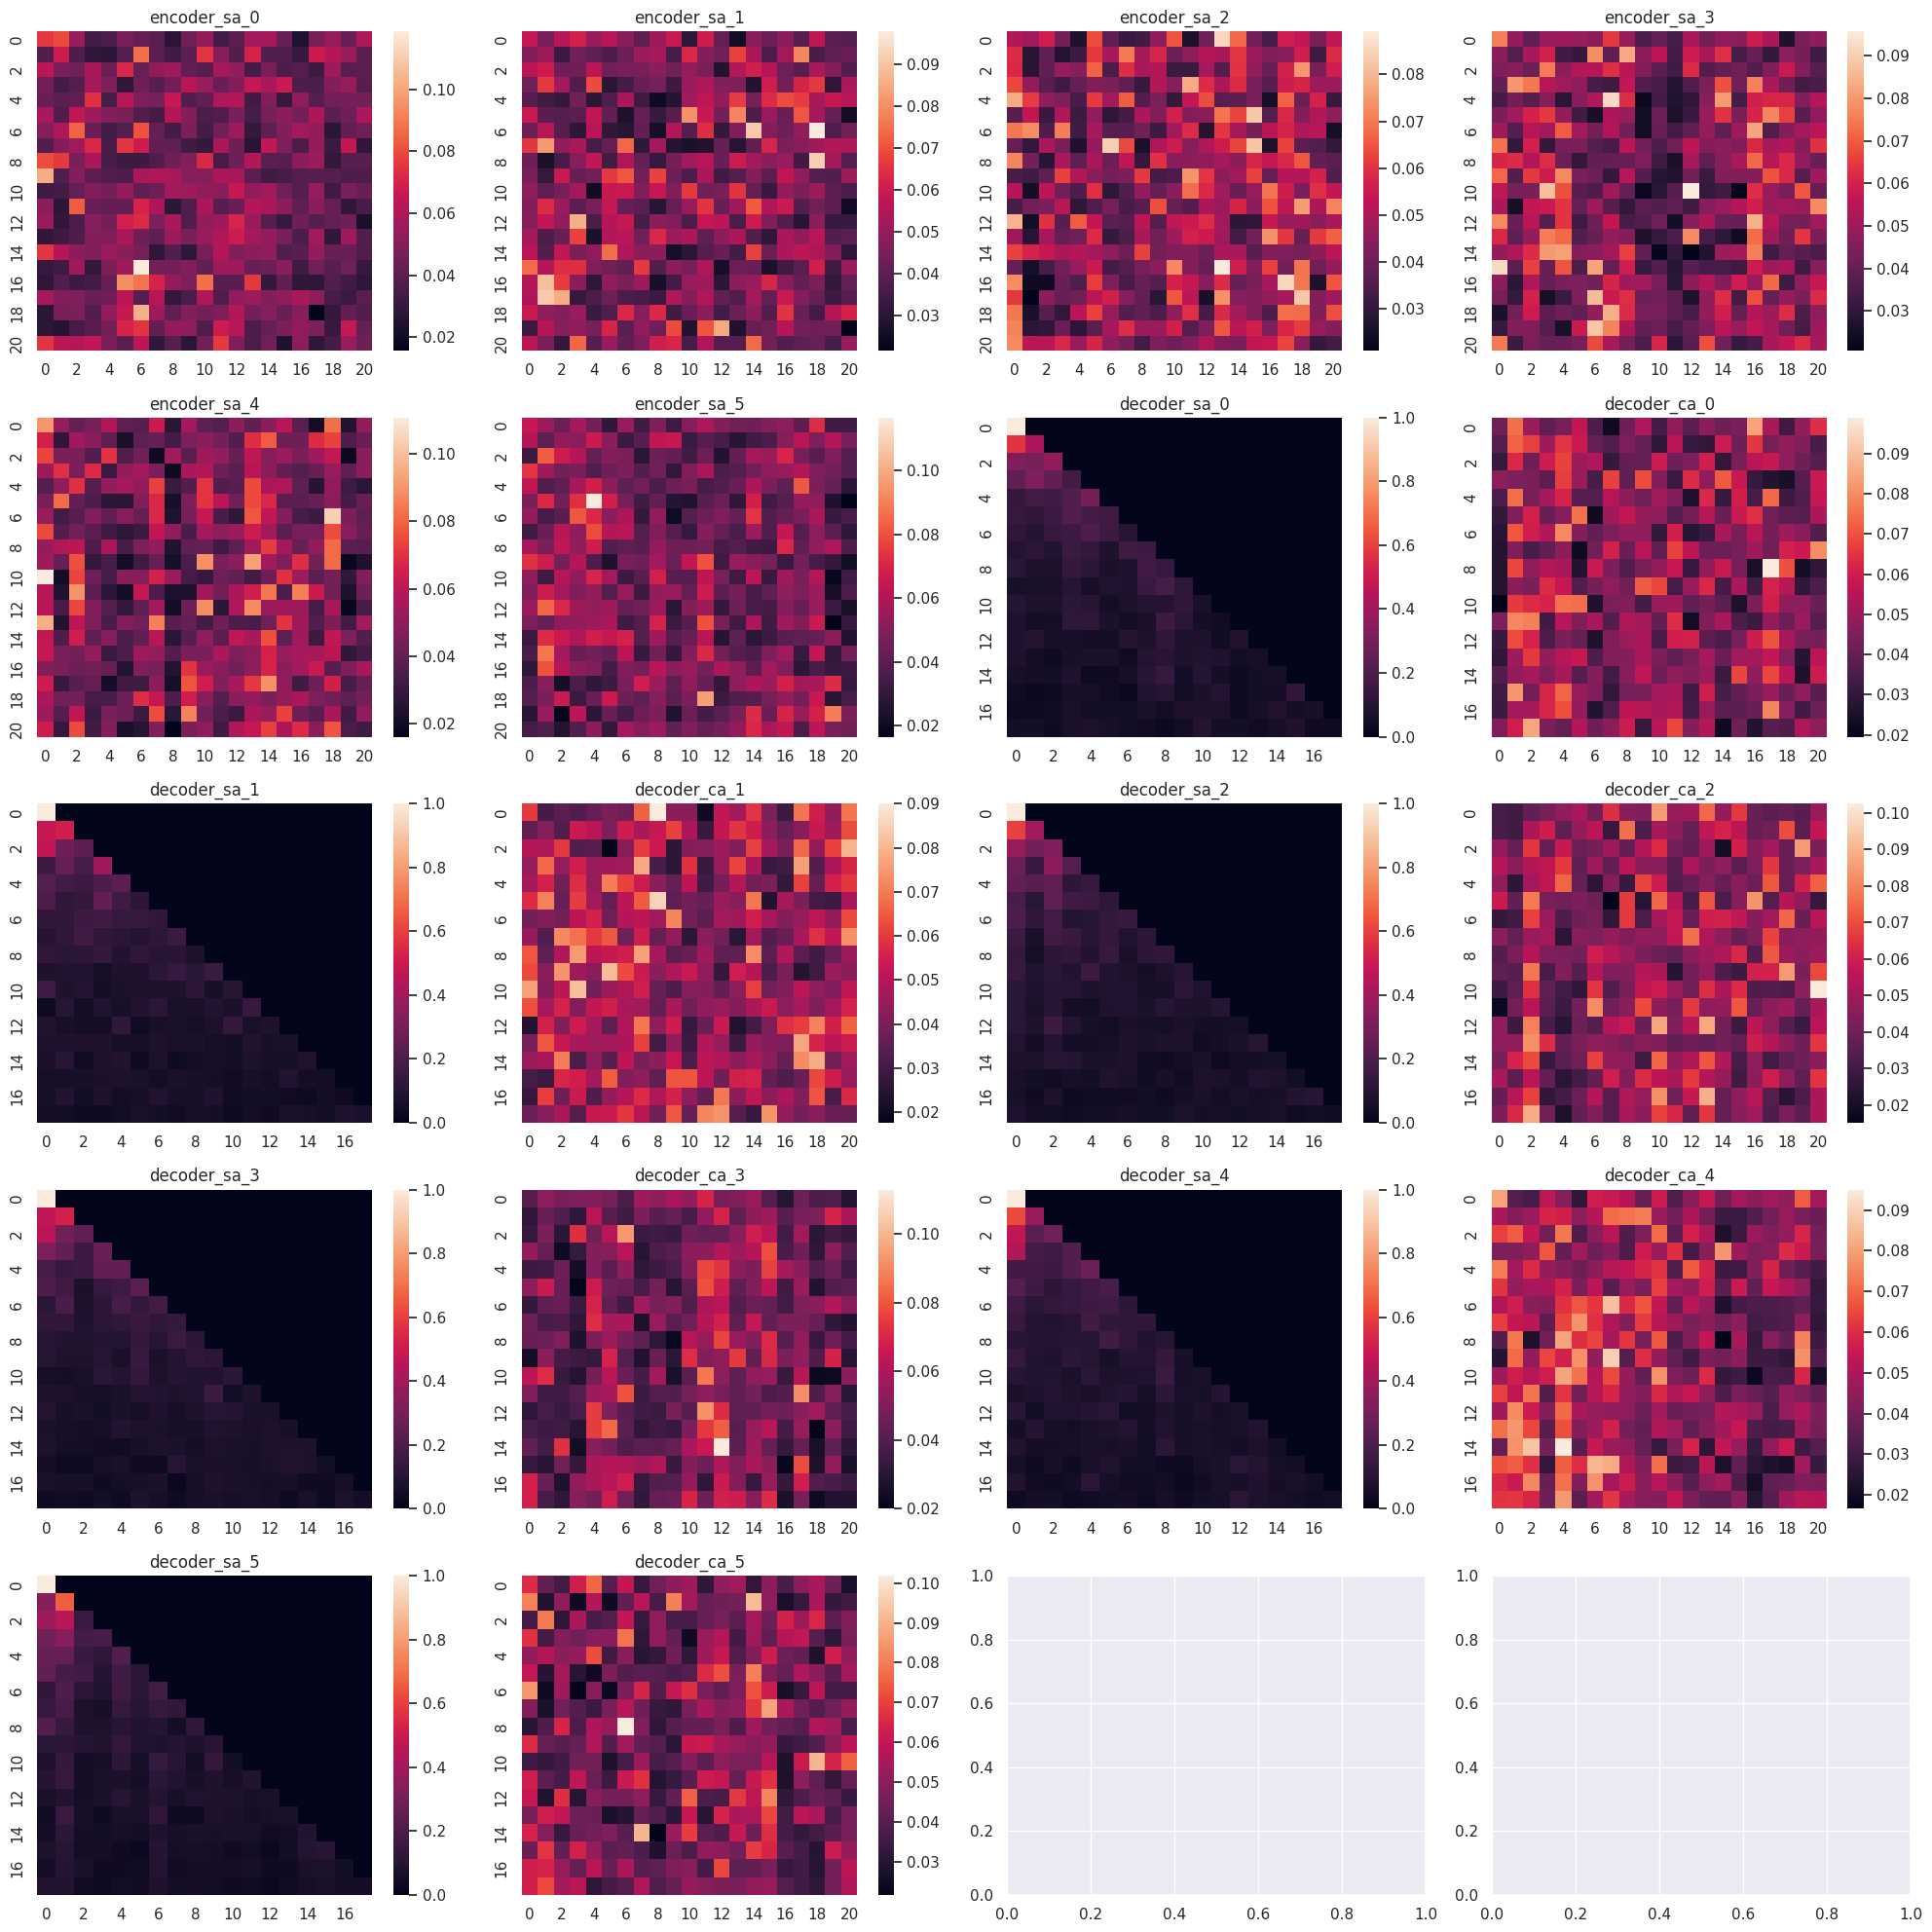

In [25]:
[plot_attention_weights(model.attention_weights, i) for i in range(1, 4)]